In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import os
import pickle
import numpy as np
from text_processing_utils import *
import glob
import math
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

In [4]:
cleaned_ratings = np.array(pickle.load(open("/content/drive/MyDrive/data/scaledata/cleaned_ratings.pickle", "rb")))
cleaned_reviews = pickle.load(open("/content/drive/MyDrive/data/scaledata/cleaned_reviews.pickle", "rb"))
vocabulary_dict = pickle.load(open("/content/drive/MyDrive/data/scaledata/vocabulary_dict.pickle", "rb"))

In [5]:
# randomly split the movie reviews data into training/testing parts (80:20)
np.random.seed(7654321)
train_indices = np.random.choice(np.arange(len(cleaned_ratings)), int(len(cleaned_ratings)*0.8), replace=False)
test_indices = np.setdiff1d(np.arange(len(cleaned_ratings)), train_indices)
print(len(train_indices), len(test_indices))
train_bow = convert_bow([cleaned_reviews[i] for i in train_indices])
test_bow = convert_bow([cleaned_reviews[i] for i in test_indices])
train_y = cleaned_ratings[train_indices]
test_y = cleaned_ratings[test_indices]

4004 1002


In [6]:
K = 24 # number of topics
V = len(vocabulary_dict) # vocabulary size

In [7]:
## Loading the optimized global parameters from the model training phase
np.random.seed(12345)
di = 3
new_alpha = pickle.load(open("/content/drive/MyDrive/data/scaledata/diagnostic_{}/alpha.pickle".format(di), "rb"))
new_xi = pickle.load(open("/content/drive/MyDrive/data/scaledata/diagnostic_{}/xi.pickle".format(di), "rb"))
new_eta = pickle.load(open("/content/drive/MyDrive/data/scaledata/diagnostic_{}/eta.pickle".format(di), "rb"))
new_delta = pickle.load(open("/content/drive/MyDrive/data/scaledata/diagnostic_{}/delta.pickle".format(di), "rb"))
new_Lambda = pickle.load(open("/content/drive/MyDrive/data/scaledata/diagnostic_{}/Lambda.pickle".format(di), "rb"))

input_data_x = test_bow
input_data_y = test_y
fpath = "fragmented_output_files_new/" # where to store the temporary fragmented files during parallelized E steps
if not os.path.exists(fpath[:-1]):
    os.makedirs(fpath[:-1])
else:
    for fn in glob.glob(fpath + "*"):
        os.remove(fn)
epsilon = 1e-4 # stopping criteria for convergence in E step
predict = True # prediction mode for evaluating the test set

## Run one iteration of unsupervised E step (parallelized) to identify the optimal local variational parameters for all documents in the test set.
## The optimized phi identified from the unsupervised batch VI will be used to generate the predictions for response variable y in the test set
%run -i "parallelized_sLDA_E_step.py" # unsupervised batch VI for sLDA is way faster than supervised one
all_gamma = [pickle.load(open(fn, "rb")) for fn in glob.glob(fpath + "gamma*")]
new_gamma_dict = merge_dict(all_gamma)
new_gamma = create_gamma_matrix(new_gamma_dict)
all_phi = [pickle.load(open(fn, "rb")) for fn in glob.glob(fpath + "phi*")]
new_phi = merge_dict(all_phi)

In [8]:
# Topic words of each topic learned from training sLDA, with corresponding coefficients (eta)
inverse_vocabulary_dict = {v:k for k,v in vocabulary_dict.items()}
for t in range(K):
    word_indices = np.argsort(new_Lambda[t,:])[::-1][:10]
    print("Topic {}:".format(t+1), [inverse_vocabulary_dict[j] for j in word_indices], "eta =", new_eta[t])

Topic 1: ['ca', 'last', 'screen', 'place', 'however', 'thing', 'actor', 'again', 'emotional', 'society'] eta = 0.5420136542861539
Topic 2: ['movies', 'world', 'why', 'sex', 'bit', 'seem', 'full', 'humor', 'where', 'comes'] eta = 0.5990251451379386
Topic 3: ['line', 'details', 'subject', 'subscribe', 'word', 'except', 'act', 'men', 'williams', 'elements'] eta = 0.5491415726947874
Topic 4: ['day', 'thin', 'red', 'songs', 'parker', 'gorgeous', 'offering', 'proves', 'robert', 'wife'] eta = 0.629138610398088
Topic 5: ['everything', 'narrative', 'leave', 'adult', 'along', 'relationship', 'political', 'take', 'go', 'couple'] eta = 0.5945069775151459
Topic 6: ['action', 'star', 'big', 'moments', 'watching', 'takes', 'half', 'effects', 'human', 'under'] eta = 0.5527803637409084
Topic 7: ['kids', 'seems', 'actors', 'motion', 'far', 'once', 'rating', 'feature', 'situations', 'pg'] eta = 0.6324658352966749
Topic 8: ['age', 'original', 'version', 'since', 'production', 'three', 'use', 'de', 'sort',

In [9]:
# Generate predictions for the response variable y for the test set:
# For Gaussian response, y_hat = E[phi_bar^T eta]
phi_bar = {k:v.mean(axis=0) for k,v in new_phi.items()}
pred_y = np.empty((len(test_y),))
for indx in range(len(test_y)):
    pred_y[indx] = np.dot(phi_bar[indx], new_eta)

In [10]:
# performance metrics:
def predictive_R2(test_y, pred_y):
    return 1 - np.mean((test_y - pred_y)**2) / np.var(test_y)

print("Predictive R^2 =", predictive_R2(test_y, pred_y))
print("Pearson correlation coefficient =", pearsonr(test_y, pred_y).statistic)

Predictive R^2 = 0.0011751991614907809
Pearson correlation coefficient = 0.06018433371159451


In [11]:
new_eta

array([0.54201365, 0.59902515, 0.54914157, 0.62913861, 0.59450698,
       0.55278036, 0.63246584, 0.59013787, 0.58941938, 0.61300688,
       0.57814871, 0.56619624, 0.5254716 , 0.60688953, 0.57661013,
       0.56441555, 0.57935363, 0.58491847, 0.58258286, 0.56396459,
       0.59298569, 0.61574898, 0.54513873, 0.61468715])

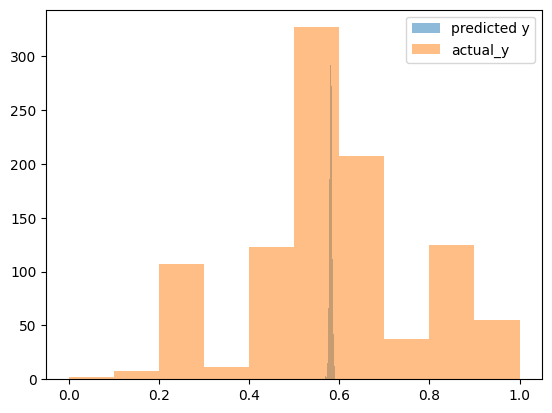

In [12]:
# Compare the predicted histogram of predicted vs. actual y values
plt.hist(pred_y, alpha=0.5, label='x')
plt.hist(test_y, alpha=0.5, label='y')
plt.legend(['predicted y', 'actual_y'], loc='upper right')
plt.show()